In [1]:
# IMPORTS + CONSTANTS
import numpy as np
import pandas as pd
import util

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
actynames = [
             'W_Validate application','W_Call after offers', 'W_Assess potential fraud wrapper',
             'W_Call incomplete files', 'W_Complete application', 'W_Handle leads',
             'W_Personal loan collection', 'W_Shortened completion'
            ]

df = pd.read_csv('workitems.csv', delimiter=',', index_col=0)
df.head()

Case ID                Activity          Start Timestamp  \
10   Application_652823628  W_Validate application  2016/01/13 11:10:55.145   
11   Application_652823628            A_Validating  2016/01/13 11:10:55.973   
15   Application_652823628  W_Validate application  2016/01/14 11:39:51.494   
16   Application_652823628            A_Validating  2016/01/14 11:39:51.556   
29  Application_1691306052  W_Validate application  2016/01/07 07:40:08.560   

         Complete Timestamp                 Delta Trans  \
10  2016/01/13 11:10:55.145  11 days 01:40:26.512000000   
11  2016/01/13 11:10:55.973   0 days 00:00:00.828000000   
15  2016/01/14 11:39:51.494   0 days 04:23:30.520000000   
16  2016/01/14 11:39:51.556   0 days 00:00:00.062000000   
29  2016/01/07 11:29:49.725   4 days 22:37:03.214000000   

                   Delta Exec                       Delta  Status  \
10  0 days 00:00:00.000000000  11 days 01:40:26.512000000       1   
11  0 days 00:00:00.000000000   0 days 00:00:00.828000000       1   
15  0 days 00:00:00.000000000   0 days 04:23:30.520000000       1   
16  0 days 00:00:00.000000000   0 days 00:00:00.062000000       1   
29  0 days 03:49:41.165000000   5 days 02:26:44.379000000       1   

                     owner  
10  W_Validate application  
11  W_Validate application  
15  W_Validate application  
16  W_Validate application  
29  W_Validate application

In [2]:
#Data wrangling 1 - converting strings to timestamps
df['Delta Exec'] = pd.to_timedelta(df['Delta Exec'])
df['Delta'] = pd.to_timedelta(df['Delta'])
df['Delta Trans'] = pd.to_timedelta(df['Delta Trans'])


# print "column groups", df.columns.to_series().groupby(df.dtypes).groups

#Data wrangling 2 - getting the workitens
maskworkitems = df['Activity'].isin(actynames)
workitemsdf   = df[ maskworkitems ]



36520.6101548 166585.791427 10.1446139319 46.2738309519


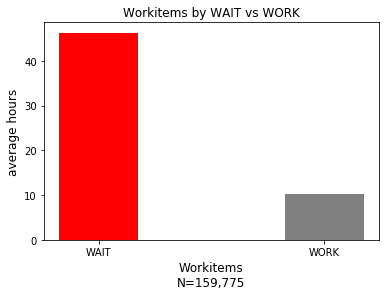

In [4]:
#Throughtput time DELAY vs EXECUTION TIME (1/2)
#For global plot - consider frequency of all those events 
#First consider all instances which Delta is greater then a second
#Second get all activities where df['Activity'].isin(actynames)
# Equivalent to get Delta Exec? 
# even W* that occur within other workitems are legit - sometimes the analyst needs applicant input
# to conclude a step
# 159775 [u'W_Validate application' u'W_Call incomplete files'
#  u'W_Call after offers' u'W_Complete application' u'W_Shortened completion'
#  u'W_Handle leads']

# threshold   = pd.Timedelta('1 Second')
# workitemsdf = df[df['Delta'] > threshold]


#workitemsdf = df[ df['Activity'].isin(actynames) ]


# 159775 [u'W_Validate application' u'W_Call incomplete files'
#  u'W_Call after offers' u'W_Complete application' u'W_Shortened completion'
#  u'W_Handle leads'] N = delayexecdf.shape[0]
workitemsnames = workitemsdf['Activity'].unique()
N = workitemsdf.shape[0]


worksecs    =  workitemsdf['Delta Exec'].dt.total_seconds().sum() / N 
delaysecs   =  workitemsdf['Delta Trans'].dt.total_seconds().sum() / N 


work =  util.seconds2hours( worksecs )
delay = util.seconds2hours( delaysecs )
print worksecs, delaysecs, work, delay


title = 'Workitems by WAIT vs WORK'
plt.title('Workitems by WAIT vs WORK')
xlabel = "Workitems\nN=%s"%("{:,}".format(N))
plt.xlabel(xlabel,fontsize=12)
plt.ylabel('average hours',fontsize=12)
plt.bar(range(2), (delay, work), align='center', width=0.35, color=('red','gray'))
plt.xticks(range(2), ('WAIT', 'WORK'))
plt.savefig("throughput_analysis_3_" + "_".join(title.split(' ')).lower() + ".eps", format='eps', dpi=1000)
plt.show()




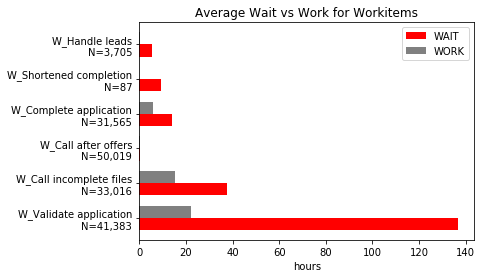

In [5]:
#Throughtput time DELAY vs EXECUTION TIME PER W* (2/2)
n = len(workitemsnames)
grouplen   = []
workhours  = []
delayhours = []
ticks      = []

for workitem in workitemsnames:

    tmpdf = workitemsdf[workitemsdf['Activity'] == workitem]

    grouplen.append(tmpdf.shape[0])     
    worksecs =  tmpdf['Delta Exec'].dt.total_seconds().sum()  / grouplen[-1] 
    delaysecs = tmpdf['Delta Trans'].dt.total_seconds().sum() / grouplen[-1] 
        
    work =  util.seconds2hours( worksecs )
    delay = util.seconds2hours( delaysecs )

    workhours.append(work)
    delayhours.append(delay)
    ticks.append("%s\nN=%s"%(workitem,"{:,}".format(grouplen[-1])))


#PLOTING EVERYTHING
fig, ax = plt.subplots()
height = 0.35       # the width of the bars
ind   = np.array(xrange(n))
rects1 = ax.barh(ind, delayhours, height=height,color='red')
rects2 = ax.barh(ind+height,  workhours, height=height,color='gray')

title = 'Average Wait vs Work for Workitems'
ax.set_xlabel('hours')
ax.set_title(title)
ax.set_yticks(ind + height / 2)
ax.set_yticklabels(ticks)
ax.legend((rects1[0], rects2[0]), ('WAIT', 'WORK'))

plt.savefig("throughput_analysis_3_" + "_".join(title.split(' ')).lower() + ".eps", format='eps', dpi=1000)
plt.show()

In [6]:
#BREAKDOWN - Preparation
#Remove workitems from complete dataframe
breakdowndf    = df.loc[(~maskworkitems)]
print breakdowndf.shape[0] + workitemsdf.shape[0]


print breakdowndf.head()

368673
                   Case ID      Activity          Start Timestamp  \
11   Application_652823628  A_Validating  2016/01/13 11:10:55.973   
16   Application_652823628  A_Validating  2016/01/14 11:39:51.556   
30  Application_1691306052  A_Validating  2016/01/07 07:40:09.412   
31  Application_1691306052      A_Denied  2016/01/07 11:29:49.671   
32  Application_1691306052     O_Refused  2016/01/07 11:29:49.710   

         Complete Timestamp     Delta Trans Delta Exec           Delta  \
11  2016/01/13 11:10:55.973 00:00:00.828000     0 days 00:00:00.828000   
16  2016/01/14 11:39:51.556 00:00:00.062000     0 days 00:00:00.062000   
30  2016/01/07 07:40:09.412 00:00:00.852000     0 days 00:00:00.852000   
31  2016/01/07 11:29:49.671 03:49:40.259000     0 days 03:49:40.259000   
32  2016/01/07 11:29:49.710 00:00:00.039000     0 days 00:00:00.039000   

    Status                   owner  
11       1  W_Validate application  
16       1  W_Validate application  
30       1  W_Validate

In [7]:
print breakdowndf['Activity'].unique()
otheractivities = ['A_Validating', 'A_Concept','O_Created','O_Sent (mail and online)','O_Sent (online only)','W_Assess potential fraud','W_Personal Loan collection']

['A_Validating' 'A_Denied' 'O_Refused' 'O_Returned' 'A_Incomplete'
 'O_Accepted' 'A_Pending' 'O_Cancelled' 'O_Create Offer' 'O_Created'
 'O_Sent (online only)' 'O_Sent (mail and online)' 'A_Cancelled'
 'W_Assess potential fraud' 'A_Complete' 'A_Accepted' 'A_Concept'
 'W_Personal Loan collection']


In [8]:
pivotdf  = breakdowndf
#Data wrangling convert to other
maskother =  pivotdf['Activity'].isin(otheractivities)

pivotdf.loc[maskother,'Activity'] = 'Others'
maskmanual = pivotdf['Delta'].dt.total_seconds() > 5
pivotdf = pivotdf.loc[maskmanual] 

pivotdf['Delta'] = pivotdf['Delta'].dt.total_seconds() / (3600)
tables = []
tables.append( pd.pivot_table(pivotdf, values=['Delta'], columns=['Activity'], aggfunc=len)    )
tables.append( pd.pivot_table(pivotdf, values=['Delta'], columns=['Activity'], aggfunc=np.sum)    )
tables.append( pd.pivot_table(pivotdf, values=['Delta'], columns=['Activity'], aggfunc=np.mean)    )
tables.append( pd.pivot_table(pivotdf, values=['Delta'], columns=['Activity'], aggfunc=np.std)    )
tables.append( pd.pivot_table(pivotdf, values=['Delta'], columns=['Activity'], aggfunc=np.min)    )
tables.append( pd.pivot_table(pivotdf, values=['Delta'], columns=['Activity'], aggfunc=np.median)    )
tables.append( pd.pivot_table(pivotdf, values=['Delta'], columns=['Activity'], aggfunc=np.max)    )

table = pd.concat(tables, axis=0)

    
    
print table

table.to_csv('throughput_analysis_3_activities.csv', sep=',')


Activity     A_Accepted    A_Cancelled       A_Denied     O_Accepted  \
Delta      18936.000000     513.000000    1561.000000    2491.000000   
Delta     147538.382109  181619.792672  106757.863893  117827.933273   
Delta          7.791423     354.034684      68.390688      47.301459   
Delta         24.989175     421.187370      93.847603      54.566765   
Delta          0.005121       0.001969       0.001602       0.003862   
Delta          0.117546     168.117330      49.528937      24.731364   
Delta        701.125395    2931.174092    2117.776551     701.114028   

Activity  O_Cancelled  O_Create Offer    O_Returned        Others  
Delta      370.000000    21853.000000   9079.000000  19998.000000  
Delta     7685.289233    49204.427016  25239.287131  58162.562284  
Delta       20.771052        2.251610      2.779963      2.908419  
Delta      105.477461       30.849067     21.189343     32.504234  
Delta        0.001451        0.002317      0.001390      0.001396  
Delta        0.

/Users/Varela/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/Varela/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
